# <center> Model building

I will use following models:
1. XGBoost
2. LightGBM
3. Stacking

Evaluation metric: MAPE

In [1]:
%store -r X_train_val
%store -r X_test
%store -r y_train_val
%store -r y_test

In [10]:
import numpy as np
import pandas as pd 

import xgboost as xgb
from xgboost import plot_importance

import warnings
import matplotlib.pyplot as plt
%matplotlib inline 

from plotly.offline import init_notebook_mode, iplot
from plotly import graph_objs as go
from plotly.subplots import make_subplots
import plotly.express as px

# Initialize plotly
init_notebook_mode(connected=True)

from IPython.core.debugger import set_trace
from time import time

from tqdm import tqdm
tqdm.pandas(desc="")
warnings.filterwarnings("ignore")
import os


# SKLEARN

from sklearn.model_selection import RandomizedSearchCV, TimeSeriesSplit, KFold
from scipy.stats import randint as sp_randint
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.metrics import r2_score

# LightGBM
from lightgbm import LGBMRegressor
import lightgbm as lgb

# Sklearn-pandas
from sklearn_pandas import CategoricalImputer, FunctionTransformer, DataFrameMapper

# Bayessian Optimization
from bayes_opt import BayesianOptimization
from hyperopt import hp
from hyperopt import fmin, tpe, space_eval
from hyperopt import STATUS_OK, Trials, fmin, hp, tpe

# vecstack
from vecstack import stacking

# Transformers
from features_transformers import DateFeatureExtractor, TSFreshTransformer
from split_dataset import split_dataset, split_and_transform

In [40]:
def mape(y_test, y_predicted):
    """
    Calculate MAPE of the forecast.    
    """
    e = y_test - y_predicted
    
    p = 100 * e / y_test
    
    p = np.where(p == np.inf, 0, p) 
    p = np.where(p == np.nan, 0, p)
    return np.mean(np.abs(p))

Save model

In [38]:
params = {
    'n_estimators': 300,
    'eta': 0.01,
    'max_depth': 4,
    'early_stopping_rounds':30,
    'objective': 'reg:squarederror',
    'seed': 1
}

dtrain = xgb.DMatrix(X_train_val, label=y_train_val)
dvalid = xgb.DMatrix(X_test, label=y_test)

progress = dict()
watchlist = [(dvalid, 'eval'), (dtrain, 'train')]

num_round = int(params['n_estimators'])

gbm_model = xgb.train(params, dtrain, num_round,
                      evals=watchlist,
                      verbose_eval=True,
                      evals_result=progress)

predictions = gbm_model.predict(dvalid)

score = mape(y_test, predictions)
score

[0]	eval-rmse:10.8463	train-rmse:5.28762
[1]	eval-rmse:10.8434	train-rmse:5.28121
[2]	eval-rmse:10.8406	train-rmse:5.27543
[3]	eval-rmse:10.8378	train-rmse:5.26906
[4]	eval-rmse:10.835	train-rmse:5.26222
[5]	eval-rmse:10.8323	train-rmse:5.25605
[6]	eval-rmse:10.8296	train-rmse:5.24902
[7]	eval-rmse:10.8269	train-rmse:5.23968
[8]	eval-rmse:10.8243	train-rmse:5.234
[9]	eval-rmse:10.8217	train-rmse:5.22881
[10]	eval-rmse:10.8192	train-rmse:5.22408
[11]	eval-rmse:10.8168	train-rmse:5.21343
[12]	eval-rmse:10.8144	train-rmse:5.20789
[13]	eval-rmse:10.8115	train-rmse:5.20238
[14]	eval-rmse:10.8091	train-rmse:5.1978
[15]	eval-rmse:10.8066	train-rmse:5.19331
[16]	eval-rmse:10.8044	train-rmse:5.1885
[17]	eval-rmse:10.8021	train-rmse:5.18406
[18]	eval-rmse:10.7999	train-rmse:5.17952
[19]	eval-rmse:10.7977	train-rmse:5.17474
[20]	eval-rmse:10.7953	train-rmse:5.17038
[21]	eval-rmse:10.7931	train-rmse:5.16572
[22]	eval-rmse:10.7911	train-rmse:5.16178
[23]	eval-rmse:10.7892	train-rmse:5.15758
[24]	ev

[195]	eval-rmse:10.6882	train-rmse:4.86669
[196]	eval-rmse:10.6872	train-rmse:4.86514
[197]	eval-rmse:10.6876	train-rmse:4.86465
[198]	eval-rmse:10.6875	train-rmse:4.86404
[199]	eval-rmse:10.6875	train-rmse:4.86343
[200]	eval-rmse:10.6879	train-rmse:4.8629
[201]	eval-rmse:10.6882	train-rmse:4.86212
[202]	eval-rmse:10.6882	train-rmse:4.86074
[203]	eval-rmse:10.6881	train-rmse:4.8601
[204]	eval-rmse:10.6881	train-rmse:4.85953
[205]	eval-rmse:10.6885	train-rmse:4.85908
[206]	eval-rmse:10.6884	train-rmse:4.85755
[207]	eval-rmse:10.6888	train-rmse:4.85683
[208]	eval-rmse:10.6892	train-rmse:4.85644
[209]	eval-rmse:10.6891	train-rmse:4.85592
[210]	eval-rmse:10.6894	train-rmse:4.85553
[211]	eval-rmse:10.6894	train-rmse:4.85496
[212]	eval-rmse:10.6899	train-rmse:4.85457
[213]	eval-rmse:10.6891	train-rmse:4.85279
[214]	eval-rmse:10.6894	train-rmse:4.85238
[215]	eval-rmse:10.6895	train-rmse:4.85184
[216]	eval-rmse:10.6893	train-rmse:4.85042
[217]	eval-rmse:10.6896	train-rmse:4.84978
[218]	eval-rm

inf

In [52]:
np.sum(y_test - np.floor(predictions))

-5338.0

In [33]:
mape_test_score = mape(gbm_model.predict(dvalid), y_test)
r2_test_score = r2_score(gbm_model.predict(dvalid), y_test)

print(f"mape_test_score: {mape_test_score}")
print(f"r2_test_score: {r2_test_score}")

mape_test_score: 54.73810577392578
r2_test_score: -36.41731700445793


In [32]:
mape_train_score = mape(gbm_model.predict(dtrain), y_train_val)
r2_train_score = r2_score(gbm_model.predict(dtrain), y_train_val)

print(f"mape_test_score: {mape_train_score}")
print(f"r2_test_score: {r2_train_score}")

mape_test_score: 45.931663513183594
r2_test_score: -8.49584083639348


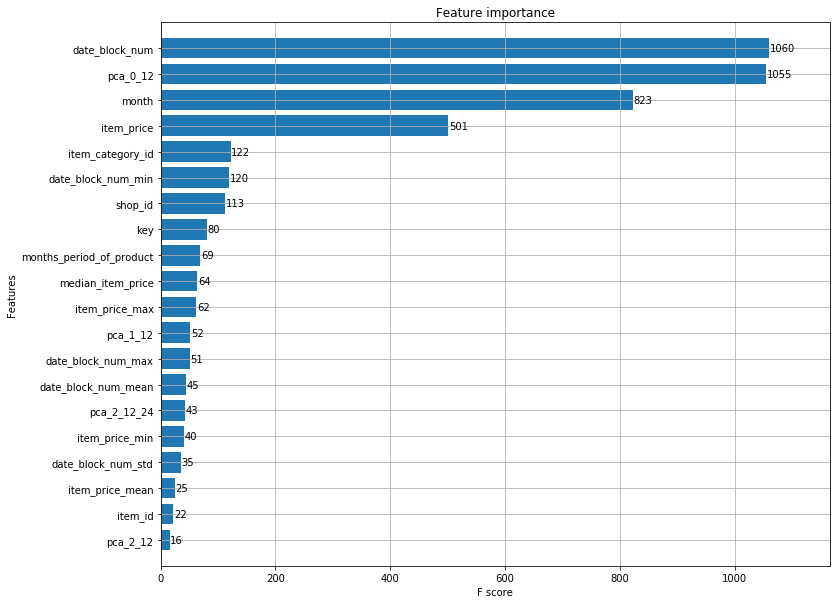

In [39]:
fig, ax = plt.subplots(figsize=(12,10))
xgb.plot_importance(gbm_model, max_num_features=20, height=0.8, ax=ax)
plt.show()

In [65]:
len(progress['eval']['rmse'])

300

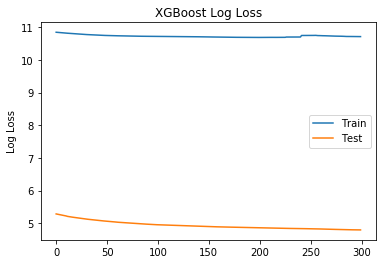

In [67]:
# make predictions for test data
y_pred = gbm_model.predict(dvalid)
predictions = np.round(y_pred)
# evaluate predictions
accuracy = mape(y_test, predictions)
# retrieve performance metrics
epochs = len(progress['eval']['rmse'])
x_axis = range(0, epochs)
# plot log loss
fig, ax = plt.subplots()
ax.plot(x_axis, progress['eval']['rmse'], label='Train')
ax.plot(x_axis, progress['train']['rmse'], label='Test')
ax.legend()
plt.ylabel('Log Loss')
plt.title('XGBoost Log Loss')
plt.show()

In [55]:
cat_feats = ['shop_id', 'key', 'item_category_id', 'item_id', 'month', 'year', 'date_block_num']

lgbm = LGBMRegressor(
    boosting_type= 'gbdt',
    objective = 'rmse',
    metric = "rmse",
    max_depth = 4,
    n_estimators = 300,
    colsample_bytree=0.7,
    min_child_weight = 300,
    reg_alpha = 1,
    reg_lambda = 1,
    random_state = 1,
)

lgbm.fit(
    X_train_val, 
    y_train_val, 
    eval_metric="rmse", 
    eval_set=[(X_train_val, y_train_val), (X_test, y_test)], 
    verbose=10, 
    categorical_feature = cat_feats)

[10]	training's rmse: 4.93542	valid_1's rmse: 10.7122
[20]	training's rmse: 4.81598	valid_1's rmse: 10.7033
[30]	training's rmse: 4.74244	valid_1's rmse: 10.7051
[40]	training's rmse: 4.72252	valid_1's rmse: 10.7034
[50]	training's rmse: 4.69817	valid_1's rmse: 10.7057
[60]	training's rmse: 4.67284	valid_1's rmse: 10.712
[70]	training's rmse: 4.65889	valid_1's rmse: 10.7121
[80]	training's rmse: 4.63562	valid_1's rmse: 10.7116
[90]	training's rmse: 4.62659	valid_1's rmse: 10.7173
[100]	training's rmse: 4.61926	valid_1's rmse: 10.7177
[110]	training's rmse: 4.6132	valid_1's rmse: 10.7188
[120]	training's rmse: 4.60228	valid_1's rmse: 10.7198
[130]	training's rmse: 4.59263	valid_1's rmse: 10.7156
[140]	training's rmse: 4.57917	valid_1's rmse: 10.7159
[150]	training's rmse: 4.561	valid_1's rmse: 10.7125
[160]	training's rmse: 4.55236	valid_1's rmse: 10.7138
[170]	training's rmse: 4.54471	valid_1's rmse: 10.7058
[180]	training's rmse: 4.53246	valid_1's rmse: 10.7079
[190]	training's rmse: 

LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=0.7,
              importance_type='split', learning_rate=0.1, max_depth=4,
              metric='rmse', min_child_samples=20, min_child_weight=300,
              min_split_gain=0.0, n_estimators=300, n_jobs=-1, num_leaves=31,
              objective='rmse', random_state=1, reg_alpha=1, reg_lambda=1,
              silent=True, subsample=1.0, subsample_for_bin=200000,
              subsample_freq=0)

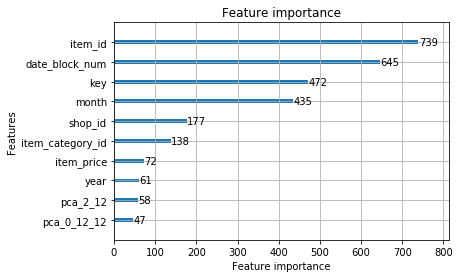

In [35]:
ax = lgb.plot_importance(lgbm, max_num_features=10)
plt.show()

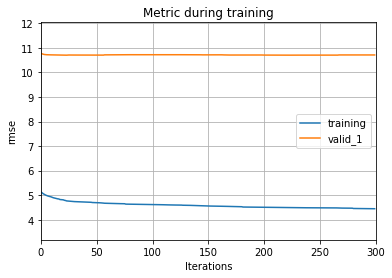

In [36]:
ax = lgb.plot_metric(lgbm)
plt.show()

# <center> Ensembling

In [76]:
import pickle
models = [lgbm, xgb]
s1_train, s1_test = stacking(models,
                           pd.concat([X_train_val, ] ), y_train_val, X_test,
                           regression=True,
                           mode='oof_pred_bag',
                           random_state=25,
                           verbose=2
                          )

task:         [regression]
metric:       [mean_absolute_error]
mode:         [oof_pred_bag]
n_models:     [1]

model  0:     [LGBMRegressor]
    fold  0:  [0.73905428]
    fold  1:  [0.94454948]
    fold  2:  [0.90556172]
    fold  3:  [1.36783669]
    ----
    MEAN:     [0.98925054] + [0.23180145]
    FULL:     [0.98925054]



In [87]:
xgb_lev2 = xgb.XGBRegressor(learning_rate=0.04, 
                        n_estimators=900,
                        max_depth=3,
                        n_jobs=-1,
                        random_state=17
                       )

# Fit the 2nd level model on the output of level 1
xgb_lev2.fit(s1_train, y_train_val)

[20:31:06] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.04, max_delta_step=0,
             max_depth=3, min_child_weight=1, missing=None, n_estimators=900,
             n_jobs=-1, nthread=None, objective='reg:linear', random_state=17,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
             silent=None, subsample=1, verbosity=1)

In [88]:
%store xgb_lev2

Stored 'xgb_lev2' (XGBRegressor)
